In [ ]:
import io
import requests
import pandas as pd
import numpy as np
from numpy import mean, isnan, asarray, polyfit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score
from sklearn.pipeline import Pipeline
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier, PassiveAggressiveClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

#SVM
from sklearn import svm

#Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB

#Tensorflow (Keras)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer

from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!pip install deep-translator
from deep_translator import GoogleTranslator

     |████████████████████████████████| 97 kB 3.7 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [ ]:
url = 'https://raw.githubusercontent.com/indobenchmark/indonlu/master/dataset/emot_emotion-twitter/train_preprocess.csv'
download = requests.get(url).content
train_df = pd.read_csv(io.StringIO(download.decode('utf-8')))
train_df = train_df.dropna()
train_df.head(10)

,label,tweet
0,happy,Ini adalah hal yang paling membahagiakan saat ...
1,anger,[USERNAME] [USERNAME] Dari pertama [USERNAME] ...
2,fear,yaudah kalo emang belum berani potong rambut p...
3,fear,"Jadi semalam, gw rekap, eh intinya yg gw usaha..."
4,anger,temen2 masa kecil yang turned out being asshol...
5,sadness,Terkadang apa yang kau dapati dan miliki saat ...
6,fear,TAMSIL ISLAM NUSANTARA. Karena kau cuma tiang ...
7,anger,[USERNAME] Skrg gini saja. Sy balik pertanyaan...
8,love,"Kalo kamuuuuuu, kamuu itu specialll. Cintanya ..."
9,happy,Kasarnya dia bilang kalo pake lg dengerin musi...


In [ ]:
train_df.shape

(3521, 2)

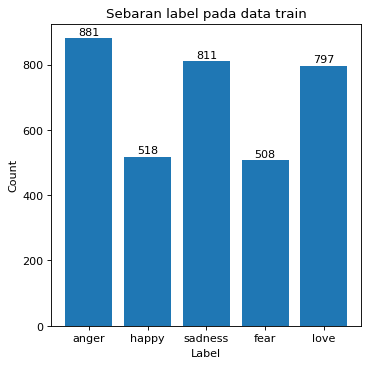

In [ ]:
def labels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]+10, y[i], ha = 'center')
plt.figure(figsize=(5,5), dpi=80)
plt.bar(train_df["label"].value_counts().index.tolist(), train_df.groupby('label')["tweet"].nunique().tolist())
labels(train_df["label"].value_counts().index.tolist(), train_df.groupby('label')["tweet"].nunique().tolist())
plt.title('Sebaran label pada data train')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [ ]:
#change Sentiment column into number that represent its categories

category_to_index = {"anger":0, "happy":1, "sadness":2, "fear": 3, "love": 4}
names_to_ids = lambda n: np.array([category_to_index.get(x) for x in n])
train_df["label"] = names_to_ids(train_df["label"])
train_df

,label,tweet
0,1,Ini adalah hal yang paling membahagiakan saat ...
1,0,[USERNAME] [USERNAME] Dari pertama [USERNAME] ...
2,3,yaudah kalo emang belum berani potong rambut p...
3,3,"Jadi semalam, gw rekap, eh intinya yg gw usaha..."
4,0,temen2 masa kecil yang turned out being asshol...
...,...,...
3516,3,[USERNAME] [USERNAME] Bcs doi w anak pelayaran...
3517,0,"Sekali , dua kali , tiga kali , lama2 bosan ju..."
3518,0,[USERNAME] [USERNAME] [USERNAME] [USERNAME] [U...
3519,3,Aku takut tulisan ini terbaca di saat kamu ngg...


In [ ]:
url_colloquial = 'https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv'
download = requests.get(url_colloquial).content
kamus_alay = pd.read_csv(io.StringIO(download.decode('utf-8')))
kamus_alay

,slang,formal,In-dictionary,context,category1,category2,category3
0,woww,wow,1,wow,elongasi,0,0
1,aminn,amin,1,Selamat ulang tahun kakak tulus semoga panjang...,elongasi,0,0
2,met,selamat,1,Met hari netaas kak!? Wish you all the best @t...,abreviasi,0,0
3,netaas,menetas,1,Met hari netaas kak!? Wish you all the best @t...,afiksasi,elongasi,0
4,keberpa,keberapa,0,Birthday yg keberpa kak?,abreviasi,0,0
...,...,...,...,...,...,...,...
15001,gataunya,enggak taunya,0,Ini kaya nenek2 ya beb gataunya agnezz @yugime...,akronim,0,0
15002,gtau,enggak tau,0,Stidaknya mrka may berkarya Dan berusaha yg tr...,akronim,abreviasi,0
15003,gatau,enggak tau,0,Ih gatau malu,akronim,0,0
15004,fans2,fan-fan,0,Jkt48 adalah tempat di mana sesama fans saling...,reduplikasi,naturalisasi,0


In [ ]:
'''
new_tweet = []
for tw in train_df['tweet']:
  for slang in kamus_alay['slang']:
    if slang in tw:
      idx = kamus_alay.index[kamus_alay['slang']==slang].tolist()[0]
      tw.replace(slang, kamus_alay['formal'][idx])
  new_tweet.append(tw)
'''

In [ ]:
'''
train_df['tweet_new'] = pd.DataFrame(new_tweet)
train_df
'''

,label,tweet,tweet_new
0,1,Ini adalah hal yang paling membahagiakan saat ...,Ini adalah hal yang paling membahagiakan saat ...
1,0,[USERNAME] [USERNAME] Dari pertama [USERNAME] ...,[USERNAME] [USERNAME] Dari pertama [USERNAME] ...
2,3,yaudah kalo emang belum berani potong rambut p...,yaudah kalo emang belum berani potong rambut p...
3,3,"Jadi semalam, gw rekap, eh intinya yg gw usaha...","Jadi semalam, gw rekap, eh intinya yg gw usaha..."
4,0,temen2 masa kecil yang turned out being asshol...,temen2 masa kecil yang turned out being asshol...
...,...,...,...
3516,3,[USERNAME] [USERNAME] Bcs doi w anak pelayaran...,[USERNAME] [USERNAME] Bcs doi w anak pelayaran...
3517,0,"Sekali , dua kali , tiga kali , lama2 bosan ju...","Sekali , dua kali , tiga kali , lama2 bosan ju..."
3518,0,[USERNAME] [USERNAME] [USERNAME] [USERNAME] [U...,[USERNAME] [USERNAME] [USERNAME] [USERNAME] [U...
3519,3,Aku takut tulisan ini terbaca di saat kamu ngg...,Aku takut tulisan ini terbaca di saat kamu ngg...


In [ ]:
!pip install PySastrawi

     |████████████████████████████████| 210 kB 5.2 MB/s 


In [ ]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

#tweet = [[word.lower() for word in train_df['tweet'].tolist()] for train_df['tweet'] in train_df]
#print(type(tweet))
tweet = []
for i in train_df['tweet']:
  text = stemmer.stem(i)
  tweet.append(text)

In [ ]:
train_df['tweet_cleaned'] = pd.DataFrame(tweet)
train_df

,label,tweet,tweet_cleaned
0,1,Ini adalah hal yang paling membahagiakan saat ...,ini adalah hal yang paling bahagia saat bias f...
1,0,[USERNAME] [USERNAME] Dari pertama [USERNAME] ...,username username dari pertama username duduk ...
2,3,yaudah kalo emang belum berani potong rambut p...,yaudah kalo emang belum berani potong rambut p...
3,3,"Jadi semalam, gw rekap, eh intinya yg gw usaha...",jadi malam gw rekap eh inti yg gw usahain kerj...
4,0,temen2 masa kecil yang turned out being asshol...,temen2 masa kecil yang turned out being asshol...
...,...,...,...
3516,3,[USERNAME] [USERNAME] Bcs doi w anak pelayaran...,username username bcs doi w anak layar tp emg ...
3517,0,"Sekali , dua kali , tiga kali , lama2 bosan ju...",sekali dua kali tiga kali lama2 bosan juga ya ...
3518,0,[USERNAME] [USERNAME] [USERNAME] [USERNAME] [U...,username username username username username u...
3519,3,Aku takut tulisan ini terbaca di saat kamu ngg...,aku takut tulis ini baca di saat kamu nggak ng...


##Batas

In [ ]:
def translator(text):
  text = GoogleTranslator(source='id', target='en').translate(text)
  #text = TextBlob(text).translate(to="en")
  return text

In [ ]:
'''
# Applying Translator Function (Pandas)
train_df['tweet_translated'] = train_df['tweet'].map(lambda x: translator(x))
train_df
'''

,label,tweet,tweet_translated
0,1,Ini adalah hal yang paling membahagiakan saat ...,This is the happiest thing when I can take a p...
1,0,[USERNAME] [USERNAME] Dari pertama [USERNAME] ...,[USERNAME] [USERNAME] From the first time [USE...
2,3,yaudah kalo emang belum berani potong rambut p...,"okay, if you don't dare to cut your hair short..."
3,3,"Jadi semalam, gw rekap, eh intinya yg gw usaha...","So last night, I recap, the point is that what..."
4,0,temen2 masa kecil yang turned out being asshol...,Childhood friends who have turned out to be as...
...,...,...,...
3516,3,[USERNAME] [USERNAME] Bcs doi w anak pelayaran...,[USERNAME] [USERNAME] Thank you for being a sa...
3517,0,"Sekali , dua kali , tiga kali , lama2 bosan ju...","Once, twice, three times, you get bored for a ..."
3518,0,[USERNAME] [USERNAME] [USERNAME] [USERNAME] [U...,[USERNAME] [USERNAME] [USERNAME] [USERNAME] [U...
3519,3,Aku takut tulisan ini terbaca di saat kamu ngg...,I'm afraid this writing will be read when you ...


In [ ]:
def remove_stopwords(lemma):
    #lemmatises and then removes stopwords
    lemma = [lemmatiser.lemmatize(word) for word in lemma if word not in (stop_english) and (word.isalpha())]
    lemma = " ".join(lemma) #joins the words back into a single string
    return lemma

#slits each string into a list of words using tokenizer
train_df["tweet_final"] = train_df["tweet_cleaned"].apply(word_tokenize)

lemmatiser = WordNetLemmatizer()
stop_english = Counter(stopwords.words())
train_df["tweet_final"] = train_df["tweet_final"].apply(remove_stopwords)

In [ ]:
train_df.head(10)

,label,tweet,tweet_cleaned,tweet_final
0,1,Ini adalah hal yang paling membahagiakan saat ...,ini adalah hal yang paling bahagia saat bias f...,yang bahagia bias foto elf returnofthelittlepr...
1,0,[USERNAME] [USERNAME] Dari pertama [USERNAME] ...,username username dari pertama username duduk ...,username username username duduk bangku jabat ...
2,3,yaudah kalo emang belum berani potong rambut p...,yaudah kalo emang belum berani potong rambut p...,yaudah kalo emang berani potong rambut pendek ...
3,3,"Jadi semalam, gw rekap, eh intinya yg gw usaha...",jadi malam gw rekap eh inti yg gw usahain kerj...,malam gw rekap eh inti yg gw usahain kerja nya...
4,0,temen2 masa kecil yang turned out being asshol...,temen2 masa kecil yang turned out being asshol...,yang turned asshole kalo cewe hijrah kalo cowo...
5,2,Terkadang apa yang kau dapati dan miliki saat ...,terkadang apa yang kau dapat dan milik saat in...,terkadang yang kau milik orang yang mengingink...
6,3,TAMSIL ISLAM NUSANTARA. Karena kau cuma tiang ...,tamsil islam nusantara karena kau cuma tiang y...,tamsil islam nusantara kau tiang yang pancang ...
7,0,[USERNAME] Skrg gini saja. Sy balik pertanyaan...,username skrg gin saja sy balik tanya boleh ka...,username skrg gin sy kah sy yg mahasiswa umi m...
8,4,"Kalo kamuuuuuu, kamuu itu specialll. Cintanya ...",kalo kamuuuuuu kamuu itu specialll cinta juga ...,kalo kamuuuuuu kamuu specialll cinta kalah yan...
9,1,Kasarnya dia bilang kalo pake lg dengerin musi...,kasar dia bilang kalo pake lg dengerin musik y...,kasar bilang kalo pake lg dengerin musik yg kl...


In [ ]:
#define the Tokeniser
tokeniser = Tokenizer(num_words=1000, lower=True)

#ceate the corpus by finding the most common 
tokeniser.fit_on_texts(train_df["tweet_final"])

In [ ]:
text_tokens = tokeniser.texts_to_matrix(list(train_df["tweet_final"]))

In [ ]:
#combining the dataframe with the tokens
full_df = pd.concat([train_df, pd.DataFrame(text_tokens)], sort=False, axis=1)
full_df.shape

(3521, 1004)

In [ ]:
#remove the sentiment into new variable
label = full_df["label"]

#drop all non-useful columns
full_df = full_df.drop(["label", "tweet", "tweet_cleaned", "tweet_final"], axis=1)

In [ ]:
full_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3516,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3517,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3518,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3519,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(full_df, label, test_size=0.2, random_state=1)
x_train.shape, y_train.shape, x_test.shape

((2816, 1000), (2816,), (705, 1000))

In [ ]:
label.shape

(3521,)

In [ ]:
full_df.shape

(3521, 1000)

In [ ]:
'''
# create the dataset
def get_dataset(n_samples=100):
	X = full_df
	y = label
	return X, y
 
# get a list of models to evaluate
def get_models():
	models = list()
	models.append(LogisticRegression())
	models.append(RidgeClassifier())
	models.append(SGDClassifier())
	models.append(PassiveAggressiveClassifier())
	models.append(KNeighborsClassifier())
	models.append(DecisionTreeClassifier())
	models.append(ExtraTreeClassifier())
	models.append(LinearSVC())
	models.append(SVC())
	models.append(GaussianNB())
	models.append(AdaBoostClassifier())
	models.append(BaggingClassifier())
	models.append(RandomForestClassifier())
	models.append(ExtraTreesClassifier())
	models.append(GaussianProcessClassifier())
	models.append(GradientBoostingClassifier())
	models.append(LinearDiscriminantAnalysis())
	models.append(QuadraticDiscriminantAnalysis())
	return models
 
# evaluate the model using a given test condition
def evaluate_model(cv, model):
	# get the dataset
	X, y = get_dataset()
	# evaluate the model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	# return scores
	return mean(scores)
 
# define test conditions
ideal_cv = LeaveOneOut()
cv = KFold(n_splits=10, shuffle=True, random_state=1)
# get the list of models to consider
models = get_models()
# collect results
ideal_results, cv_results = list(), list()
# evaluate each model
for model in models:
	# evaluate model using each test condition
	cv_mean = evaluate_model(cv, model)
	ideal_mean = evaluate_model(ideal_cv, model)
	# check for invalid results
	if isnan(cv_mean) or isnan(ideal_mean):
		continue
	# store results
	cv_results.append(cv_mean)
	ideal_results.append(ideal_mean)
	# summarize progress
	print('>%s: ideal=%.3f, cv=%.3f' % (type(model).__name__, ideal_mean, cv_mean))
# calculate the correlation between each test condition
corr, _ = pearsonr(cv_results, ideal_results)
print('Correlation: %.3f' % corr)
# scatter plot of results
pyplot.scatter(cv_results, ideal_results)
# plot the line of best fit
coeff, bias = polyfit(cv_results, ideal_results, 1)
line = coeff * asarray(cv_results) + bias
pyplot.plot(cv_results, line, color='r')
# label the plot
pyplot.title('10-fold CV vs LOOCV Mean Accuracy')
pyplot.xlabel('Mean Accuracy (10-fold CV)')
pyplot.ylabel('Mean Accuracy (LOOCV)')
# show the plot
pyplot.show()
'''

In [ ]:
#test model using Keras
keras = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=1000, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(5, activation='sigmoid')
])
keras.compile(
     loss='sparse_categorical_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)

In [ ]:
keras.fit(
     x_train, y_train,
     validation_data=(x_test, y_test),
     epochs=30,
     callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)]
     )

Epoch 1/30
88/88 [==============================] - 2s 7ms/step - loss: 1.5864 - accuracy: 0.2362 - val_loss: 1.5160 - val_accuracy: 0.2993
Epoch 2/30
88/88 [==============================] - 0s 3ms/step - loss: 1.3778 - accuracy: 0.3743 - val_loss: 1.2692 - val_accuracy: 0.4511
Epoch 3/30
88/88 [==============================] - 0s 3ms/step - loss: 1.0553 - accuracy: 0.5646 - val_loss: 1.1842 - val_accuracy: 0.5433
Epoch 4/30
88/88 [==============================] - 0s 4ms/step - loss: 0.8224 - accuracy: 0.6903 - val_loss: 1.2459 - val_accuracy: 0.5390
Epoch 5/30
88/88 [==============================] - 0s 3ms/step - loss: 0.6783 - accuracy: 0.7532 - val_loss: 1.2971 - val_accuracy: 0.5475
Epoch 6/30
88/88 [==============================] - 0s 4ms/step - loss: 0.5495 - accuracy: 0.8079 - val_loss: 1.4234 - val_accuracy: 0.5504
Epoch 7/30
88/88 [==============================] - 0s 3ms/step - loss: 0.4446 - accuracy: 0.8626 - val_loss: 1.5867 - val_accuracy: 0.5461
Epoch 8/30
88/88 [==

In [ ]:
#Creates a reverse dictionary
index_to_category = {0:"anger", 1:"happy", 2:"sadness", 3:"fear", 4:"love"}

#Creates lambda functions, applying the appropriate dictionary
ids_to_names = lambda n: np.array([index_to_category.get(x) for x in n])

In [ ]:
#Generate predictions
y_pred = np.argmax(keras.predict(x_test), axis=1)

#Assign labels to predictions and test data
y_pred_labels = ids_to_names(y_pred)
y_test_labels = ids_to_names(y_test)

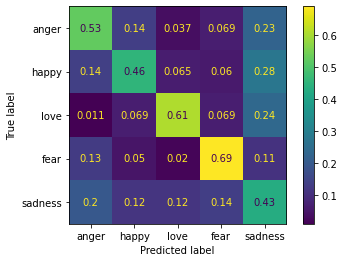

In [ ]:
y_unique = list(set(y_test_labels))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels = y_unique, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_unique)
disp.plot()

In [ ]:
acc_keras = accuracy_score(y_test, y_pred)
f1_keras = f1_score(y_test, y_pred, average = 'macro')
print('Accuracy score for Tensorflow (Keras): ' + str('{:04.2f}'.format(acc_keras*100)) + '%')
print('F1 score for Tensorflow (Keras): ' + str('{:04.2f}'.format(f1_keras*100)) + '%')

Accuracy score for Tensorflow (Keras): 52.20%
F1 score for Tensorflow (Keras): 53.59%


In [ ]:
#Logistic Regression
logreg = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter = 1000)
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
acc_logreg = round(accuracy_score(y_test, y_pred)*100,2)
f1_logreg = round(f1_score(y_test, y_pred, average = 'macro')*100,2)
print('Accuracy score for Logistic Regression  : ' + str('{:04.2f}'.format(acc_logreg)) + '%')
print('F1 score for Logistic Regression        : ' + str('{:04.2f}'.format(f1_logreg)) + '%')

Accuracy score for Logistic Regression  : 63.40%
F1 score for Logistic Regression        : 64.38%


In [ ]:
# Support Vector Machines
svc = svm.SVC(kernel='linear')
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
acc_svm = round(accuracy_score(y_test, y_pred)*100,2)
f1_svm = round(f1_score(y_test, y_pred, average = 'macro')*100,2)
print('Accuracy score for SVM  : ' + str('{:04.2f}'.format(acc_svm)) + '%')
print('F1 score for SVM        : ' + str('{:04.2f}'.format(f1_svm)) + '%')

Accuracy score for SVM  : 57.59%
F1 score for SVM        : 58.71%


In [ ]:
#K-Nearest Neighbor
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(x_train, y_train)
predict = knn.predict(x_test)
acc_knn = round(accuracy_score(y_test, predict)*100,2)
f1_knn = round(f1_score(y_test, predict, average="macro")*100,2)
print('Accuracy score for KNN  : ' + str('{:04.2f}'.format(acc_knn)) + '%')
print('F1 score for KNN        : ' + str('{:04.2f}'.format(f1_knn)) + '%')

Accuracy score for KNN  : 42.41%
F1 score for KNN        : 37.45%


In [ ]:
#Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)
predict = decision_tree.predict(x_test)
acc_decision_tree = round(accuracy_score(y_test, predict)*100,2)
f1_decision_tree = round(f1_score(y_test, predict, average="macro")*100,2)
print('Accuracy score for Decision Tree  : ' + str('{:04.2f}'.format(acc_decision_tree)) + '%')
print('F1 score for Decision Tree        : ' + str('{:04.2f}'.format(f1_decision_tree)) + '%')

Accuracy score for Decision Tree  : 51.06%
F1 score for Decision Tree        : 52.68%


In [ ]:
#Ridge
ridge = RidgeClassifier()
ridge.fit(x_train, y_train)
predict = ridge.predict(x_test)
acc_ridge = round(accuracy_score(y_test, predict)*100,2)
f1_ridge = round(f1_score(y_test, predict, average="macro")*100,2)
print('Accuracy score for Ridge  : ' + str('{:04.2f}'.format(acc_ridge)) + '%')
print('F1 score for Ridge        : ' + str('{:04.2f}'.format(f1_ridge)) + '%')

Accuracy score for Ridge  : 60.43%
F1 score for Ridge        : 61.44%


In [ ]:
#Random Forest
randomforest = RandomForestClassifier()
randomforest.fit(x_train, y_train)
predict = randomforest.predict(x_test)
acc_randomforest = round(accuracy_score(y_test, predict)*100,2)
f1_randomforest = round(f1_score(y_test, predict, average="macro")*100,2)
print('Accuracy score for Random Forest  : ' + str('{:04.2f}'.format(acc_randomforest)) + '%')
print('F1 score for Random Forest        : ' + str('{:04.2f}'.format(f1_randomforest)) + '%')

Accuracy score for Random Forest  : 60.57%
F1 score for Random Forest        : 62.39%


In [ ]:
#Perceptron
perceptron = Perceptron()
perceptron.fit(x_train, y_train)
predict = perceptron.predict(x_test)
acc_perceptron = round(accuracy_score(y_test, predict)*100,2)
f1_perceptron = round(f1_score(y_test, predict, average="macro")*100,2)
print('Accuracy score for Perceptron  : ' + str('{:04.2f}'.format(acc_perceptron)) + '%')
print('F1 score for Perceptron        : ' + str('{:04.2f}'.format(f1_perceptron)) + '%')

Accuracy score for Perceptron  : 54.33%
F1 score for Perceptron        : 55.22%


In [ ]:
#Linear SVC
lin_svc = LinearSVC()
lin_svc.fit(x_train, y_train)
predict = lin_svc.predict(x_test)
acc_lin_svc = round(accuracy_score(y_test, predict)*100,2)
f1_lin_svc = round(f1_score(y_test, predict, average="macro")*100,2)
print('Accuracy score for Linear SVC  : ' + str('{:04.2f}'.format(acc_lin_svc)) + '%')
print('F1 score for Linear SVC        : ' + str('{:04.2f}'.format(f1_lin_svc)) + '%')

Accuracy score for Linear SVC  : 58.30%
F1 score for Linear SVC        : 58.88%


In [ ]:
#Stochastic Gradient Descent
sgdc = SGDClassifier()
sgdc.fit(x_train, y_train)
y_pred = sgdc.predict(x_test)
acc_sgdc = round(accuracy_score(y_test, y_pred)*100,2)
f1_sgdc = round(f1_score(y_test, y_pred, average = 'macro')*100,2)
print('Accuracy score for SGDClassifier  : ' + str('{:04.2f}'.format(acc_sgdc)) + '%')
print('F1 score for SGDClassifier        : ' + str('{:04.2f}'.format(f1_sgdc)) + '%')

Accuracy score for SGDClassifier  : 59.01%
F1 score for SGDClassifier        : 59.54%


In [ ]:
scaler = MinMaxScaler()
nb_train = scaler.fit_transform(x_train)
nb_test = scaler.fit_transform(x_test)

mnb = MultinomialNB()
mnb.fit(nb_train, y_train)
y_pred = mnb.predict(nb_test)
acc_mnb = round(accuracy_score(y_test, y_pred)*100,2)
f1_mnb = round(f1_score(y_test, y_pred, average = 'macro')*100,2)
print('Accuracy score for MultinomialNB  : ' + str('{:04.2f}'.format(acc_mnb)) + '%')
print('F1 score for MultinomialNB        : ' + str('{:04.2f}'.format(f1_mnb)) + '%')

Accuracy score for MultinomialNB  : 58.44%
F1 score for MultinomialNB        : 57.79%


In [ ]:
cnb = ComplementNB()
cnb.fit(nb_train, y_train)
y_pred = cnb.predict(nb_test)
acc_cnb = round(accuracy_score(y_test, y_pred)*100,2)
f1_cnb = round(f1_score(y_test, y_pred, average = 'macro')*100,2)
print('Accuracy score for ComplementNB  : ' + str('{:04.2f}'.format(acc_cnb)) + '%')
print('F1 score for ComplementNB        : ' + str('{:04.2f}'.format(f1_cnb)) + '%')

Accuracy score for ComplementNB  : 62.70%
F1 score for ComplementNB        : 61.90%


In [ ]:
gnb = GaussianNB()
gnb.fit(x_train, y_train)
y_pred = gnb.predict(x_test)
acc_gnb = round(accuracy_score(y_test, y_pred)*100,2)
f1_gnb = round(f1_score(y_test, y_pred, average = 'macro')*100,2)
print('Accuracy score for GaussianNB  : ' + str('{:04.2f}'.format(acc_gnb)) + '%')
print('F1 score for GaussianNB        : ' + str('{:04.2f}'.format(f1_gnb)) + '%')

Accuracy score for GaussianNB  : 33.90%
F1 score for GaussianNB        : 32.81%


In [ ]:
bnb = BernoulliNB()
bnb.fit(x_train, y_train)
y_pred = bnb.predict(x_test)
acc_bnb = round(accuracy_score(y_test, y_pred)*100,2)
f1_bnb = round(f1_score(y_test, y_pred, average = 'macro')*100,2)
print('Accuracy score for BernoulliNB  : ' + str('{:04.2f}'.format(acc_bnb)) + '%')
print('F1 score for BernoulliNB        : ' + str('{:04.2f}'.format(f1_bnb)) + '%')

Accuracy score for BernoulliNB  : 58.72%
F1 score for BernoulliNB        : 58.52%


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(train_df['tweet_final'], label, test_size=0.2, random_state=1)
X_train.shape, Y_train.shape, X_test.shape

((2816,), (2816,), (705,))

In [ ]:
# Logistic Regression
logreg = Pipeline([('vector', CountVectorizer()), ('tf-idf', TfidfTransformer()), ('classifier', LogisticRegression())])
logreg.fit(X_train, Y_train)
predict = logreg.predict(X_test)
Acc_logreg = round(accuracy_score(Y_test, predict)*100,2)
F1_logreg = round(f1_score(Y_test, predict, average="macro")*100,2)
print("Accuracy score: {}".format(Acc_logreg))
print("F1 score      : {}".format(F1_logreg))

Accuracy score: 64.26
F1 score      : 65.27


In [ ]:
# Support Vector Machines
svc = Pipeline([('vector', CountVectorizer()), ('tf-idf', TfidfTransformer()), ('classifier', SVC())])
svc.fit(X_train, Y_train)
predict = svc.predict(X_test)
Acc_svc = round(accuracy_score(Y_test, predict)*100,2)
F1_svc = round(f1_score(Y_test, predict, average="macro")*100,2)
print("Accuracy score: {}".format(Acc_svc))
print("F1 score      : {}".format(F1_svc))

Accuracy score: 62.27
F1 score      : 63.05


In [ ]:
# K-Nearest Neighbours
knn = Pipeline([('vector', CountVectorizer()), ('tf-idf', TfidfTransformer()), ('classifier', KNeighborsClassifier(n_neighbors = 10))])
knn.fit(X_train, Y_train)
predict = knn.predict(X_test)
Acc_knn = round(accuracy_score(Y_test, predict)*100,2)
F1_knn = round(f1_score(Y_test, predict, average="macro")*100,2)
print("Accuracy score: {}".format(Acc_knn))
print("F1 score      : {}".format(F1_knn))

Accuracy score: 48.09
F1 score      : 47.19


In [ ]:
# Decision Tree
decision_tree = Pipeline([('vector', CountVectorizer()), ('tf-idf', TfidfTransformer()), ('classifier', DecisionTreeClassifier())])
decision_tree.fit(X_train, Y_train)
predict = decision_tree.predict(X_test)
Acc_decision_tree = round(accuracy_score(Y_test, predict)*100,2)
F1_decision_tree = round(f1_score(Y_test, predict, average="macro")*100,2)
print("Accuracy score: {}".format(Acc_decision_tree))
print("F1 score      : {}".format(F1_decision_tree))

Accuracy score: 50.78
F1 score      : 52.3


In [ ]:
# Ridge
ridge = Pipeline([('vector', CountVectorizer()), ('tf-idf', TfidfTransformer()), ('classifier', RidgeClassifier())])
ridge.fit(X_train, Y_train)
predict = ridge.predict(X_test)
Acc_ridge = round(accuracy_score(Y_test, predict)*100,2)
F1_ridge = round(f1_score(Y_test, predict, average="macro")*100,2)
print("Accuracy score: {}".format(Acc_ridge))
print("F1 score      : {}".format(F1_ridge))

Accuracy score: 65.53
F1 score      : 66.49


In [ ]:
# Random Forest
randomforest = Pipeline([('vector', CountVectorizer()), ('tf-idf', TfidfTransformer()), ('classifier', RandomForestClassifier())])
randomforest.fit(X_train, Y_train)
predict = randomforest.predict(X_test)
Acc_randomforest = round(accuracy_score(Y_test, predict)*100,2)
F1_randomforest = round(f1_score(Y_test, predict, average="macro")*100,2)
print("Accuracy score: {}".format(Acc_randomforest))
print("F1 score      : {}".format(F1_randomforest))

Accuracy score: 59.43
F1 score      : 60.68


In [ ]:
# Perceptron
perceptron = Pipeline([('vector', CountVectorizer()), ('tf-idf', TfidfTransformer()), ('classifier', Perceptron())])
perceptron.fit(X_train, Y_train)
predict = perceptron.predict(X_test)
Acc_perceptron = round(accuracy_score(Y_test, predict)*100,2)
F1_perceptron = round(f1_score(Y_test, predict, average="macro")*100,2)
print("Accuracy score: {}".format(Acc_perceptron))
print("F1 score      : {}".format(F1_perceptron))

Accuracy score: 60.85
F1 score      : 61.17


In [ ]:
# Linear SVC
lin_svc = Pipeline([('vector', CountVectorizer()), ('tf-idf', TfidfTransformer()), ('classifier', LinearSVC())])
lin_svc.fit(X_train, Y_train)
predict = lin_svc.predict(X_test)
Acc_lin_svc = round(accuracy_score(Y_test, predict)*100,2)
F1_lin_svc = round(f1_score(Y_test, predict, average="macro")*100,2)
print("Accuracy score: {}".format(Acc_lin_svc))
print("F1 score      : {}".format(F1_lin_svc))

Accuracy score: 64.11
F1 score      : 65.03


In [ ]:
# Stochastic Gradient Descent
sgd = Pipeline([('vector', CountVectorizer()), ('tf-idf', TfidfTransformer()), ('classifier', SGDClassifier())])
sgd.fit(X_train, Y_train)
predict = sgd.predict(X_test)
Acc_sgd = round(accuracy_score(Y_test, predict)*100,2)
F1_sgd = round(f1_score(Y_test, predict, average="macro")*100,2)
print("Accuracy score: {}".format(Acc_sgd))
print("F1 score      : {}".format(F1_sgd))

Accuracy score: 61.84
F1 score      : 62.35


In [ ]:
mnb = Pipeline([('vector', CountVectorizer()), ('tf-idf', TfidfTransformer()), ('classifier', MultinomialNB())])
mnb.fit(X_train, Y_train)
y_pred = mnb.predict(X_test)
Acc_mnb = round(accuracy_score(Y_test, y_pred)*100,2)
F1_mnb = round(f1_score(Y_test, y_pred, average = 'macro')*100,2)
print('Accuracy score for MultinomialNB  : ' + str('{:04.2f}'.format(acc_mnb)) + '%')
print('F1 score for MultinomialNB        : ' + str('{:04.2f}'.format(f1_mnb)) + '%')

Accuracy score for MultinomialNB  : 58.44%
F1 score for MultinomialNB        : 57.79%


In [ ]:
cnb = Pipeline([('vector', CountVectorizer()), ('tf-idf', TfidfTransformer()), ('classifier', ComplementNB())])
cnb.fit(X_train, Y_train)
y_pred = cnb.predict(X_test)
Acc_cnb = round(accuracy_score(Y_test, y_pred)*100,2)
F1_cnb = round(f1_score(Y_test, y_pred, average = 'macro')*100,2)
print('Accuracy score for ComplementNB  : ' + str('{:04.2f}'.format(Acc_cnb)) + '%')
print('F1 score for ComplementNB        : ' + str('{:04.2f}'.format(F1_cnb)) + '%')

Accuracy score for ComplementNB  : 62.13%
F1 score for ComplementNB        : 61.76%


In [ ]:
bnb = Pipeline([('vector', CountVectorizer()), ('tf-idf', TfidfTransformer()), ('classifier', BernoulliNB())])
bnb.fit(X_train, Y_train)
y_pred = bnb.predict(X_test)
Acc_bnb = round(accuracy_score(Y_test, y_pred)*100,2)
F1_bnb = round(f1_score(Y_test, y_pred, average = 'macro')*100,2)
print('Accuracy score for BernoulliNB  : ' + str('{:04.2f}'.format(Acc_bnb)) + '%')
print('F1 score for BernoulliNB        : ' + str('{:04.2f}'.format(F1_bnb)) + '%')

Accuracy score for BernoulliNB  : 51.77%
F1 score for BernoulliNB        : 44.95%


In [ ]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'SVM', 'KNN', 'Decision Tree', 'Ridge', 'Random Forest', 
              'Perceptron', 'Linear SVC', 'SGD', 'MultinomialNB', 'ComplementNB', 'BernoulliNB'],
    'Score 1': [acc_logreg, acc_svm, acc_knn, acc_decision_tree, acc_ridge, acc_randomforest, 
                acc_perceptron, acc_lin_svc, acc_sgdc, acc_mnb, acc_cnb, acc_bnb],
    'Score 2 (Pipeline)': [Acc_logreg, Acc_svc, Acc_knn, Acc_decision_tree, Acc_ridge, Acc_randomforest, 
                Acc_perceptron, Acc_lin_svc, Acc_sgd, Acc_mnb, Acc_cnb, Acc_bnb]})
models.sort_values(by='Score 1', ascending=False)

,Model,Score 1,Score 2 (Pipeline)
0,Logistic Regression,63.40,64.26
10,ComplementNB,62.70,62.13
5,Random Forest,60.57,59.43
4,Ridge,60.43,65.53
8,SGD,59.01,61.84
11,BernoulliNB,58.72,51.77
9,MultinomialNB,58.44,55.46
7,Linear SVC,58.30,64.11
1,SVM,57.59,62.27
6,Perceptron,54.33,60.85


In [ ]:
url = 'https://raw.githubusercontent.com/indobenchmark/indonlu/master/dataset/emot_emotion-twitter/valid_preprocess.csv'
download = requests.get(url).content
valid_df = pd.read_csv(io.StringIO(download.decode('utf-8')))
valid_df = valid_df.dropna()
valid_df.head(10)

,label,tweet
0,anger,[USERNAME] jaringannya mati ya? Tidak bisa dib...
1,anger,It's like a circle of stupidity. Atlit gak diu...
2,anger,[USERNAME] [USERNAME] [USERNAME] [USERNAME] [U...
3,happy,[USERNAME] Selamat Siang Sahabat Pos. Kiriman ...
4,happy,"Di hari ini, yap tepat di tanggal 23 juli dima..."
5,anger,Buat yang teriak teriak ganti presiden...giman...
6,anger,belajar agama yg tuntas jd nga ngarang dalam h...
7,happy,"Hepibesdey canteeeekk [USERNAME] panjang umur,..."
8,fear,Kok banyak yaa di kabupaten w anak muda yg men...
9,anger,"Gue emang cuek sih , bgt bgt malah tp kl ada y..."


In [ ]:
valid_df.shape

(440, 2)

In [ ]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

tweet = []
for i in valid_df['tweet']:
  text = stemmer.stem(i)
  tweet.append(text)

In [ ]:
test_df = pd.DataFrame(tweet)
test_df.rename(columns={0:'tweet_cleaned'}, inplace=True)
test_df

,tweet_cleaned
0,username jaring mati ya tidak bisa buka mobile...
1,it s like a circle of stupidity atlit gak diur...
2,username username username username username u...
3,username selamat siang sahabat pos kirim tsb s...
4,di hari ini yap tepat di tanggal 23 juli mana ...
...,...
435,username username mekanisme pilih direksi dan ...
436,ngasih tehaer ke keponakan baju dua biji celan...
437,hahaha bodo amat deehhh yg penting di video in...
438,langsung mewek baca thread ini keren maksimal ...


In [ ]:
#slits each string into a list of words using tokenizer
test_df["tweet_final"] = test_df["tweet_cleaned"].apply(word_tokenize)

lemmatiser = WordNetLemmatizer()
stop_english = Counter(stopwords.words())
test_df["tweet_final"] = test_df["tweet_final"].apply(remove_stopwords)

In [ ]:
test_df.head()

,tweet_cleaned,tweet_final
0,username jaring mati ya tidak bisa buka mobile...,username jaring mati buka mobile jkn puskesmes...
1,it s like a circle of stupidity atlit gak diur...,like circle stupidity atlit gak diurusin duit ...
2,username username username username username u...,username username username username username u...
3,username selamat siang sahabat pos kirim tsb s...,username selamat siang sahabat po kirim tsb te...
4,di hari ini yap tepat di tanggal 23 juli mana ...,yap tanggal juli gua sangatsangat special maka...


In [ ]:
test_df_final = test_df['tweet_final']

In [ ]:
#define the Tokeniser
tokeniser = Tokenizer(num_words=1000, lower=True)

#ceate the corpus by finding the most common 
tokeniser.fit_on_texts(test_df["tweet_final"])

In [ ]:
text_tokens = tokeniser.texts_to_matrix(list(test_df["tweet_final"]))

In [ ]:
#combining the dataframe with the tokens
full_test_df = pd.concat([test_df, pd.DataFrame(text_tokens)], sort=False, axis=1)
full_test_df

,tweet_cleaned,tweet_final,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,username jaring mati ya tidak bisa buka mobile...,username jaring mati buka mobile jkn puskesmes...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
1,it s like a circle of stupidity atlit gak diur...,like circle stupidity atlit gak diurusin duit ...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,username username username username username u...,username username username username username u...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,username selamat siang sahabat pos kirim tsb s...,username selamat siang sahabat po kirim tsb te...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,di hari ini yap tepat di tanggal 23 juli mana ...,yap tanggal juli gua sangatsangat special maka...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,username username mekanisme pilih direksi dan ...,username username mekanisme pilih direksi komi...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
436,ngasih tehaer ke keponakan baju dua biji celan...,ngasih tehaer keponakan baju biji celana biji ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
437,hahaha bodo amat deehhh yg penting di video in...,hahaha deehhh yg video frame danielsayang bang...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
438,langsung mewek baca thr

In [ ]:
#drop all non-useful columns
full_test_df = full_test_df.drop(["tweet_cleaned", "tweet_final"], axis=1)
full_test_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
436,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
437,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
438,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Logistic Regression
logreg = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter = 1000)
logreg.fit(x_train, y_train)
predict = logreg.predict(full_test_df)
predict

array([0, 2, 4, 0, 1, 2, 2, 0, 2, 2, 2, 4, 2, 4, 1, 1, 2, 2, 4, 3, 2, 0,
       1, 3, 2, 1, 3, 2, 0, 3, 1, 3, 2, 4, 0, 3, 1, 0, 4, 0, 1, 3, 0, 3,
       2, 0, 4, 0, 2, 4, 2, 2, 2, 3, 1, 2, 2, 2, 3, 4, 0, 1, 0, 2, 4, 3,
       0, 1, 2, 3, 4, 2, 3, 2, 2, 1, 1, 1, 4, 1, 0, 0, 1, 2, 3, 1, 2, 2,
       4, 1, 4, 1, 1, 0, 2, 1, 3, 0, 1, 2, 3, 3, 1, 0, 0, 0, 3, 0, 0, 1,
       3, 2, 0, 4, 1, 2, 0, 4, 2, 1, 2, 0, 2, 0, 0, 2, 3, 2, 4, 0, 3, 2,
       1, 2, 1, 1, 2, 2, 1, 2, 1, 1, 2, 0, 0, 0, 0, 0, 2, 2, 4, 3, 2, 2,
       0, 2, 0, 2, 2, 4, 4, 0, 4, 1, 4, 1, 2, 0, 1, 0, 2, 0, 0, 1, 3, 1,
       3, 1, 1, 2, 4, 4, 1, 1, 2, 0, 3, 1, 3, 3, 1, 4, 0, 1, 4, 2, 4, 1,
       3, 0, 2, 4, 4, 2, 2, 0, 1, 0, 0, 3, 3, 0, 1, 0, 0, 1, 0, 1, 0, 4,
       0, 0, 0, 0, 2, 1, 3, 0, 2, 2, 4, 2, 4, 3, 2, 2, 2, 0, 2, 1, 0, 1,
       2, 4, 2, 4, 0, 0, 4, 0, 2, 1, 1, 1, 4, 0, 4, 2, 4, 0, 3, 0, 4, 0,
       4, 1, 1, 1, 3, 1, 0, 0, 0, 2, 0, 4, 2, 3, 0, 0, 0, 3, 4, 3, 4, 1,
       2, 1, 2, 1, 2, 2, 2, 2, 3, 3, 3, 2, 0, 0, 0,

In [ ]:
#change Sentiment column into number that represent its categories

index_to_category = {0:"anger", 1:"happy", 2:"sadness", 3:"fear", 4:"love"}
ids_to_names = lambda n: np.array([index_to_category.get(x) for x in n])
predict = ids_to_names(predict)
valid_df['predict_label_1'] = pd.DataFrame(predict)
valid_df

,label,tweet,predict_label_1
0,anger,[USERNAME] jaringannya mati ya? Tidak bisa dib...,anger
1,anger,It's like a circle of stupidity. Atlit gak diu...,sadness
2,anger,[USERNAME] [USERNAME] [USERNAME] [USERNAME] [U...,love
3,happy,[USERNAME] Selamat Siang Sahabat Pos. Kiriman ...,anger
4,happy,"Di hari ini, yap tepat di tanggal 23 juli dima...",happy
...,...,...,...
435,anger,[USERNAME] [USERNAME] Mekanisme pemilihan dire...,anger
436,fear,Ngasih tehaer ke keponakan. Baju dua biji cela...,fear
437,love,HAHAHA BODO AMAT DEEHHH YG PENTING DI VIDEO IN...,sadness
438,sadness,"Langsung mewek baca thread ini, keren maksimal...",happy


In [ ]:
acc_score_final = accuracy_score(valid_df["label"], valid_df["predict_label_1"])*100
acc_score_final

26.81818181818182

In [ ]:
f1_score_final = f1_score(valid_df["label"], valid_df["predict_label_1"], average="macro")*100
f1_score_final

27.321750708224297

In [ ]:
# Logistic Regression
logreg = Pipeline([('vector', CountVectorizer()), ('tf-idf', TfidfTransformer()), ('classifier', LogisticRegression())])
logreg.fit(X_train, Y_train)
predict = logreg.predict(test_df_final)
predict

array([0, 2, 0, 1, 1, 0, 0, 1, 1, 3, 1, 0, 4, 2, 0, 3, 3, 2, 4, 2, 0, 1,
       2, 2, 0, 1, 3, 0, 4, 3, 0, 1, 1, 4, 1, 1, 0, 1, 2, 2, 2, 2, 0, 0,
       4, 0, 0, 2, 0, 4, 2, 2, 0, 3, 2, 0, 1, 0, 0, 4, 1, 2, 0, 1, 4, 4,
       1, 2, 0, 0, 4, 3, 1, 2, 2, 4, 0, 3, 3, 3, 1, 1, 1, 3, 2, 0, 4, 2,
       1, 1, 4, 0, 1, 2, 3, 0, 0, 2, 3, 3, 2, 0, 1, 0, 2, 1, 0, 1, 0, 1,
       4, 0, 0, 2, 4, 0, 0, 4, 1, 4, 0, 1, 3, 0, 1, 2, 2, 0, 4, 1, 0, 1,
       2, 4, 3, 0, 3, 2, 1, 4, 1, 2, 4, 0, 2, 1, 2, 0, 4, 2, 4, 4, 4, 4,
       2, 2, 1, 4, 0, 0, 4, 0, 2, 2, 0, 1, 2, 2, 2, 1, 2, 3, 2, 1, 4, 2,
       0, 4, 0, 3, 4, 2, 1, 2, 2, 2, 1, 1, 0, 1, 2, 4, 1, 3, 0, 1, 3, 1,
       0, 2, 0, 4, 2, 1, 1, 1, 4, 2, 2, 0, 0, 2, 2, 0, 1, 3, 0, 3, 0, 4,
       1, 4, 4, 3, 2, 0, 0, 0, 4, 3, 0, 4, 4, 0, 2, 0, 3, 1, 0, 0, 1, 1,
       3, 4, 0, 0, 2, 2, 1, 2, 2, 2, 2, 0, 4, 2, 0, 0, 4, 1, 2, 0, 2, 2,
       3, 0, 1, 0, 0, 0, 2, 0, 2, 2, 1, 4, 3, 2, 0, 0, 2, 3, 4, 0, 2, 1,
       3, 1, 3, 0, 1, 2, 4, 0, 3, 0, 0, 1, 2, 2, 4,

In [ ]:
#change Sentiment column into number that represent its categories

index_to_category = {0:"anger", 1:"happy", 2:"sadness", 3:"fear", 4:"love"}
ids_to_names = lambda n: np.array([index_to_category.get(x) for x in n])
predict = ids_to_names(predict)
valid_df['predict_label'] = pd.DataFrame(predict)
valid_df

,label,tweet,predict_label
0,anger,[USERNAME] jaringannya mati ya? Tidak bisa dib...,anger
1,anger,It's like a circle of stupidity. Atlit gak diu...,sadness
2,anger,[USERNAME] [USERNAME] [USERNAME] [USERNAME] [U...,anger
3,happy,[USERNAME] Selamat Siang Sahabat Pos. Kiriman ...,happy
4,happy,"Di hari ini, yap tepat di tanggal 23 juli dima...",happy
...,...,...,...
435,anger,[USERNAME] [USERNAME] Mekanisme pemilihan dire...,anger
436,fear,Ngasih tehaer ke keponakan. Baju dua biji cela...,sadness
437,love,HAHAHA BODO AMAT DEEHHH YG PENTING DI VIDEO IN...,happy
438,sadness,"Langsung mewek baca thread ini, keren maksimal...",happy


In [ ]:
f1_score_final = f1_score(valid_df["label"], valid_df["predict_label"], average="macro")*100
f1_score_final

62.02624988829856

In [ ]:
acc_score_final = accuracy_score(valid_df["label"], valid_df["predict_label"])*100
acc_score_final

61.13636363636363

In [ ]:
message = ['hari ini aku bahagia']
df = pd.DataFrame(message)

string = [str(item) for item in df[0]]
factory = StemmerFactory()
stemmer = factory.create_stemmer()

text_stem = []
for i in string:
    text = stemmer.stem(i)
    text_stem.append(text)
dataframe_stem = pd.DataFrame(text_stem)

def remove_stopwords(lemma):
    #lemmatises and then removes stopwords
    lemma = [lemmatiser.lemmatize(word) for word in lemma if word not in (stop_english) and (word.isalpha())]
    lemma = " ".join(lemma) #joins the words back into a single string
    return lemma

In [ ]:
#slits each string into a list of words using tokenizer
df_stem = dataframe_stem[0].apply(word_tokenize)

lemmatiser = WordNetLemmatizer()
stop_english = Counter(stopwords.words())
dataframe = df_stem.apply(remove_stopwords)

0    bahagia
Name: 0, dtype: object

In [ ]:
test_text = [['hari ini aku bahagia', 'hari ini aku sedih']]
test_text_df = pd.DataFrame(test_text)
test_text_df

,0,1
0,hari ini aku bahagia,hari ini aku sedih


In [ ]:
prediksi = logreg.predict(test_text_df)
prediksi

array([1])

In [ ]:
#change Sentiment column into number that represent its categories

index_to_category = {0:"anger", 1:"happy", 2:"sadness", 3:"fear", 4:"love"}
ids_to_names = lambda n: np.array([index_to_category.get(x) for x in n])
pred = ids_to_names(prediksi)
pred

array(['happy'], dtype='<U5')

##Export Model

In [ ]:
# Save Model Using Pickle
!pip install PySastrawi
import io
import requests
import pandas as pd
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import pickle
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

url = 'https://raw.githubusercontent.com/indobenchmark/indonlu/master/dataset/emot_emotion-twitter/train_preprocess.csv'
download = requests.get(url).content
dataframe = pd.read_csv(io.StringIO(download.decode('utf-8')))
dataframe = dataframe.dropna()
array = dataframe.values

label = dataframe['label']

factory = StemmerFactory()
stemmer = factory.create_stemmer()

tweet = []
for i in dataframe['tweet']:
  text = stemmer.stem(i)
  tweet.append(text)

dataframe['tweet_cleaned'] = pd.DataFrame(tweet)

def remove_stopwords(lemma):
    #lemmatises and then removes stopwords
    lemma = [lemmatiser.lemmatize(word) for word in lemma if word not in (stop_english) and (word.isalpha())]
    lemma = " ".join(lemma) #joins the words back into a single string
    return lemma

#slits each string into a list of words using tokenizer
dataframe["tweet_final"] = dataframe["tweet_cleaned"].apply(word_tokenize)

lemmatiser = WordNetLemmatizer()
stop_english = Counter(stopwords.words())
dataframe["tweet_final"] = dataframe["tweet_final"].apply(remove_stopwords)

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(dataframe['tweet_final'], label, test_size=0.2, random_state=1)
X_train.shape, Y_train.shape, X_test.shape

# Logistic Regression
logreg = Pipeline([('vector', CountVectorizer()), ('tf-idf', TfidfTransformer()), ('classifier', LogisticRegression())])
logreg.fit(X_train, Y_train)

# save the model to disk
pickl = {'model': logreg}
filename = 'emotion_detection_model.p'
pickle.dump(pickl, open(filename, 'wb'))
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model['model'].score(X_test, Y_test)
print(result)

     |████████████████████████████████| 210 kB 9.6 MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
0.6425531914893617
